In [6]:
import warnings
warnings.filterwarnings("ignore")

## 선형회귀

### 정규방정식으로 모델 파라미터 최적값 찾기

In [2]:
import numpy as np
X = 2 * np.random.rand(100,1) #균일분포 난수
y = 4+3*X+np.random.randn(100,1) #표준정규분포 난수

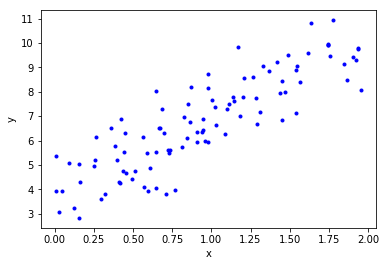

In [8]:
import matplotlib.pyplot as plt
plt.plot(X,y, "b.")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [13]:
X_b = np.c_[np.ones((100,1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [14]:
theta_best

array([[3.79711114],
       [3.16502787]])

In [17]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict # y=3x+잡음 이므로 원하는 예측값은 차례대로 4, 11

array([[ 3.79711114],
       [10.12716689]])

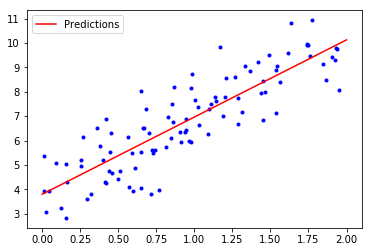

In [30]:
plt.plot(X,y,"b.")
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.legend()
plt.show()

### 최소제곱으로 모델 파라미터 최적값 찾기
- 사이킷런에서 최소제곱을 기반으로 한다.
- 최소제곱에서 최적theta = pinv(X).dot(y) (단, pinv()는 유사역행렬을 구하는 함수)
- X.T.dot(X)의 역행렬이 존재하지 않을 경우 정규방정식을 사용할 수 없지만
- 유사역행렬(=Moore penrose역행렬)은 항상 존재하기 때문에 최적theta값을 항상 구할 수 있다. 또한 계산도 간단함

In [31]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
lin_reg.intercept_, lin_reg.coef_ 

(array([3.79711114]), array([[3.16502787]]))

In [33]:
lin_reg.predict(X_new)

array([[ 3.79711114],
       [10.12716689]])

In [34]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.79711114],
       [3.16502787]])

In [35]:
np.linalg.pinv(X_b).dot(y) #유사역행렬으로 theta값 구하기

array([[3.79711114],
       [3.16502787]])

정규방정식과 SVD를 통해 선형회귀의 최적 파라미터를 찾는 방법은 
- **특성 수가 많아지면 학습이 오래 걸림**
- 샘플 수에 대해서는 선형
- 예측에 대해서는 특성 수, 샘플 수 모두 선형적으로 증가

특성 수가 많을 때 아래 GD를 사용한다.

## 경사하강법(Gradient Descent)

### full gradient descent(=batch GD)
매 스텝에서 전체 훈련셋을 사용해 gradient를 계산함. -> 느림

In [36]:
# gradient descent 구현
learning_rate = 0.1
n_iterations = 1000 #움직이는 횟수
m=100 #샘플수

theta = np.random.randn(2,1) #random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - learning_rate * gradients

theta

array([[3.79711114],
       [3.16502787]])

learning rate, n_iterations 설정
- learning rate : grid search. 단 반복 횟수 제한
- n_iterations : gradient vector가 아주 작아지면 중지

### 확률적(=무작위) 경사 하강법(stochastic gradient descnet, SGD)
매 스텝에서 무작위로 선택된 하나의 샘플데이터로 gradient를 계산함.

- 무작위성은 local minimum을 벗어날 수 있지만 global minimum에 다다르지 못할 가능성이 있다. 
- -> simulated annealing
- 시작할 때 학습률을 크게 하고, 점진적으로 줄여나감. 학습률을 결정하는 함수를 learning schedule이라고 한다.

In [38]:
n_epochs = 50
t0, t1 = 5,50

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_idx = np.random.randint(m) #복원추출을 하는데, 모든 샘플을 학습시키는 것보다 일찍 수렴하는 경향이 있음.
        xi = X_b[random_idx:random_idx+1]
        yi = y[random_idx:random_idx+1]
        gradients = 2*xi.T.dot(xi.dot(theta)-yi)
        learning_rate = learning_schedule(epoch*m +i)
        theta = theta - learning_rate*gradients
        
theta

array([[3.77437889],
       [3.10856584]])

In [42]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty=None, eta0=0.1) #max_iter : 최대 epoch, tol: tolerance. 그레디언트 벡터의 norm, eta0: learning rate.
sgd_reg.fit(X, y.ravel()) # np.ravel() : 다차원 배열을 1차원으로 풀어줌.

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.1, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [43]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.81522366]), array([3.19716347]))

### mini-batch gradient descent
- GPU를 사용한 성능 향상
- full GD 보다 시간은 덜 걸리고, SGD보다 덜 불규칙하다는 장점.

## 다항회귀

In [64]:
m=100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [65]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0], X_poly[0]

(array([0.531834]), array([0.531834  , 0.28284741]))

In [74]:
poly_features.get_feature_names()

['x0', 'x0^2']

In [66]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.97100411]), array([[0.97707136, 0.51600607]]))

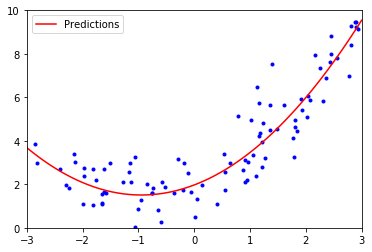

In [71]:
X_new = np.linspace(-3,3,100).reshape(100,1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")
plt.legend()
plt.axis([-3,3,0,10])
plt.show()

## 학습 곡선
모델이 과소적합되었는지, 과대적합되었는지 알아보는 방법
- 교차 검증 : 훈련 데이터의 성능은 좋으나 교차 검증 점수가 나쁜 경우 overfitting
- 학습 곡선 

In [82]:
# pyplot 한글
plt.rc('font', family='NanumGothic')

In [86]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)) :
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="training set")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="valudation set")
    plt.xlabel("훈련 세트 크기")
    plt.ylabel("RMSE")
    plt.axis([0,80,0,3])
    plt.legend()

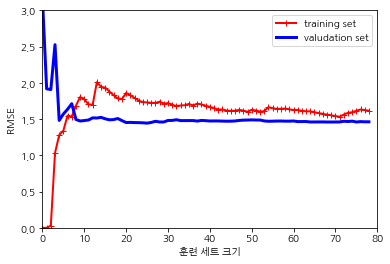

In [87]:
# 과소적합 모델의 그래프
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

- 두 곡선의 오차가 비슷함.
- 과소적합 되었기 때문에 훈련 세트를 추가해도 더 나아지지 않음.

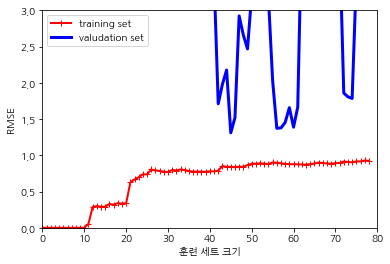

In [88]:
# 과대적합
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias = False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)

- 훈련 세트에 대한 오차는 낮아졌으나 검증 세트에 대한 오차가 이보다 높다.
- 훈련 세트를 더 추가하면 모델을 개선할 수 있음.

## 규제가 있는 선형 모델
모델의 과대적합을 해소하기 위한 한 가지 방법으로는 모델에 규제를 가하는 것. 가중치를 두어 규제를 가하는 방법 -> 릿지, 라쏘, 엘라스틱넷

### Ridge Regression
- 가중치의 제곱합이 비용함수에 더해짐. = l2 norm/2 (훈련 동안 사용되는 비용함수에만 포함되고 테스트할 때 성능지표에는 포함되지 않음) [norm참고](https://light-tree.tistory.com/125)
- 규제항에 곱해진 하이퍼파라미터가 0이면 일반 선형회귀이고, 클수록 모든 가중치의 값이 0에 가까워진다.
- 가중치의 제곱합으로 식이 이루어지기 때문에 입력 특성의 스케일에 민감하므로 스케일을 맞춰주는 것이 중요하다.

In [89]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1, solver="cholesky") # alpha : 규제항에 곱해진 하이퍼 파라미터, solver : 릿지회귀의 정규방정식을 안드레 루이 숄레스키가 변형한 방정식을 사용
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[5.09004277]])

In [91]:
sgd_reg = SGDRegressor(penalty="l2") # penalty : 비용함수에 추가할 규제 지정
sgd_reg.fit(X, y)
sgd_reg.predict([[1.5]])

array([5.05649013])

### Lasso Regression
- 가중치의 절댓값합이 비용함수에 더해짐. = l1노름
- 특성 선택을 하는 특징이 있음. 즉 덜 중요한 특성의 가중치는 0이 됨.

In [93]:
from sklearn.linear_model import Lasso

lasso_reg= Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.04893555])

In [94]:
sgd_reg_lasso = SGDRegressor(penalty="l1")
sgd_reg_lasso.fit(X,y)
sgd_reg_lasso.predict([[1.5]])

array([5.07680804])

### Elastic net regression
- ridge와 lasso를 절충한 모델. 두 규제항에 혼합비율을 곱해 더한 것을 규제항으로 사용한다.

In [95]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5) #l1_ratio : 혼합 비율
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.0452728])

#### Ridge, Lasso, Elastic net 선택
- Ridge가 기본적으로 쓰인다.
- 하지만 특성 선택이 필요하면 Lasso, Elastic net 중에서 선택하고
- 특성 수 > 훈련 샘플 수, 특성 사이에 강한 연관성이 존재하면 Elastic net을 사용한다.

### 조기 종료
- 검증 에러가 최솟값에 도달하면 훈련을 종료시키는 방법. 
- 즉 학습 곡선을 그려봤을 때 검증 에러가 일정 시간동안 최솟값(이라고 생각되는)보다 클 때 학습을 종료시키고 최솟값일 때의 파라미터를 취하는 것.

In [131]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=44)

In [154]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True, penalty=None, learning_rate = "constant", eta0=0.0005, random_state=44) 
# warm_start=True : fit() 메서드가 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련을 이어간다. 밑에서 반복문을 사용하기 때문에 max_iter=1 로 설정함.

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(299):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error :
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [155]:
best_epoch, minimum_val_error

(298, 1.0776056132650194)

In [156]:
best_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=44,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=True)

In [157]:
X_train[0], X_train_poly_scaled[0]

(array([-1.42002273]),
 array([-6.83012678e-01, -4.82142411e-01, -2.40103721e-01, -6.64225262e-01,
        -8.55302087e-02, -6.35737798e-01, -4.23270639e-02, -5.71493878e-01,
        -2.94824323e-02, -5.14569477e-01, -2.41242985e-02, -4.70478619e-01,
        -2.05748590e-02, -4.37024839e-01, -1.74843847e-02, -4.11403172e-01,
        -1.45124174e-02, -3.91451395e-01, -1.15564585e-02, -3.75649147e-01,
        -8.58254937e-03, -3.62938900e-01, -5.58523092e-03, -3.52575729e-01,
        -2.57371912e-03, -3.44024947e-01,  4.35722181e-04, -3.36895275e-01,
         3.42469925e-03, -3.30895135e-01,  6.37570196e-03, -3.25803599e-01,
         9.27371731e-03, -3.21450730e-01,  1.21068919e-02, -3.17704007e-01,
         1.48666049e-02, -3.14458790e-01,  1.75472137e-02, -3.11631515e-01,
         2.01456435e-02, -3.09154757e-01,  2.26609289e-02, -3.06973602e-01,
         2.50937681e-02, -3.05042948e-01,  2.74461197e-02, -3.03325460e-01,
         2.97208569e-02, -3.01790023e-01,  3.19214800e-02, -3.004

In [158]:
x0= X_train[0]
x0, 2 + x0 + 0.5 * x0**2

(array([-1.42002273]), array([1.58820955]))

In [159]:
sgd_reg.predict([X_train_poly_scaled[0]])

array([1.5550983])

In [161]:
best_model

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.0005, fit_intercept=True, l1_ratio=0.15,
             learning_rate='constant', loss='squared_loss', max_iter=1,
             n_iter_no_change=5, penalty=None, power_t=0.25, random_state=44,
             shuffle=True, tol=-inf, validation_fraction=0.1, verbose=0,
             warm_start=True)

In [153]:
best_model.fit(X_train_poly_scaled, y_train, )
best_model.predict([X_train_poly_scaled[0]])

array([-0.25314081])

In [160]:
best_model.predict([X_train_poly_scaled[0]])

NotFittedError: This SGDRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

문제 : fit된 상태까지 clone되어서 predict되어야하는데. 그게 안된 것 같음.

## 로지스틱 회귀